# Topic Modeling with Gensim

## Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
from gensim import corpora

plt.style.use('seaborn')

documents = [
    "Human machine interface for lab abc computer applications",
    "A survey of user opinion of computer system response time",
    "The EPS user interface management system",
    "System and human system engineering testing of EPS",
    "Relation of user perceived response time to error measurement",
    "The generation of random binary unordered trees",
    "The intersection graph of paths in trees",
    "Graph minors IV Widths of trees and well quasi ordering",
    "Graph minors A survey",
]

# remove common words and tokenize
stoplist = set('for a of the and to in'.split())
texts = [
    [word for word in document.lower().split() if word not in stoplist]
    for document in documents
]

# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

## Models

In [2]:
from gensim import models

tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [3]:
lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)
corpus_lsi = lsi_model[corpus_tfidf]

In [4]:
lda_model = models.LdaModel(corpus, id2word=dictionary, num_topics=2)
corpus_lda = lda_model[corpus]

## Document to Topic Membership

### LSI

For LSI, you will have to cluster to see which documents go into which cluster.

In [5]:
for doc, as_text in zip(corpus_lsi, documents):
    print(doc, as_text)

[(0, 0.06600783396090225), (1, -0.5200703306361849)] Human machine interface for lab abc computer applications
[(0, 0.1966759285914227), (1, -0.7609563167700056)] A survey of user opinion of computer system response time
[(0, 0.08992639972446238), (1, -0.7241860626752508)] The EPS user interface management system
[(0, 0.07585847652178009), (1, -0.6320551586003424)] System and human system engineering testing of EPS
[(0, 0.10150299184979962), (1, -0.5737308483002961)] Relation of user perceived response time to error measurement
[(0, 0.7032108939378315), (1, 0.16115180214025596)] The generation of random binary unordered trees
[(0, 0.8774787673119836), (1, 0.16758906864659157)] The intersection graph of paths in trees
[(0, 0.9098624686818582), (1, 0.1408655362871875)] Graph minors IV Widths of trees and well quasi ordering
[(0, 0.6165825350569278), (1, -0.05392907566389566)] Graph minors A survey


#### k-means

When we use [k-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), we supply the number of `k` as the number of topics. We may then get the predicted labels out for topic assignment. Note that this approach makes LSI a `hard` (not hard as in difficult, but hard as in only 1 topic per document) topic assignment approach.

In [6]:
import numpy as np
from sklearn.cluster import KMeans

np.random.seed(37)

X = np.array([[tup[1] for tup in arr] for arr in corpus_lsi])
kmeans = KMeans(n_clusters=2, random_state=37).fit(X)

In [7]:
kmeans.labels_

array([1, 1, 1, 1, 1, 0, 0, 0, 0])

In [8]:
kmeans.cluster_centers_

array([[ 0.77678367,  0.10391933],
       [ 0.10599433, -0.64219974]])

#### Plotting

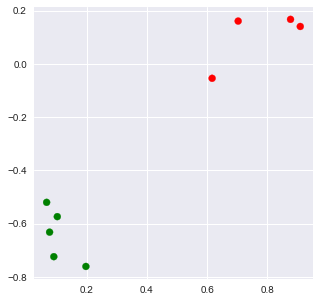

In [9]:
X = np.array([[tup[1] for tup in arr] for arr in corpus_lsi])

x = X[:,0]
y = X[:,1]
c = ['r' if i == 0 else 'g' for i in kmeans.labels_]

fig, ax = plt.subplots(figsize=(5, 5))
_ = ax.scatter(x, y, c=c)

### LDA

For LDA, the results gives you the probability of membership to each topic. Note these sum to 1.0 per document?

In [10]:
for doc, as_text in zip(corpus_lda, documents):
    print(doc, as_text)

[(0, 0.8225138), (1, 0.17748618)] Human machine interface for lab abc computer applications
[(0, 0.8862746), (1, 0.113725424)] A survey of user opinion of computer system response time
[(0, 0.30864543), (1, 0.6913546)] The EPS user interface management system
[(0, 0.8465748), (1, 0.15342525)] System and human system engineering testing of EPS
[(0, 0.84070456), (1, 0.1592954)] Relation of user perceived response time to error measurement
[(0, 0.6859117), (1, 0.31408828)] The generation of random binary unordered trees
[(0, 0.73916143), (1, 0.2608386)] The intersection graph of paths in trees
[(0, 0.5695467), (1, 0.4304533)] Graph minors IV Widths of trees and well quasi ordering
[(0, 0.17607693), (1, 0.82392305)] Graph minors A survey


#### Plotting

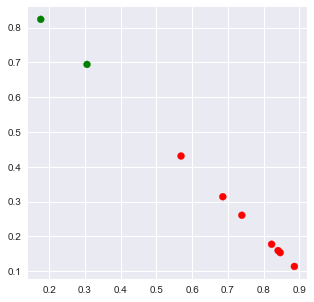

In [11]:
X = np.array([[tup[1] for tup in arr] for arr in corpus_lda])

x = X[:,0]
y = X[:,1]
c = ['r' if np.argmax(X[r,:]) == 0 else 'g' for r in range(X.shape[0])]

fig, ax = plt.subplots(figsize=(5, 5))
_ = ax.scatter(x, y, c=c)

## Id-Word and Word-Id

Knowing that IDs map to words (tokens) and vice-versa when we want to diagnose/troubleshoot how the weights associate with words within a topic.

In [12]:
print(lsi_model.id2word.token2id)

{'computer': 0, 'human': 1, 'interface': 2, 'response': 3, 'survey': 4, 'system': 5, 'time': 6, 'user': 7, 'eps': 8, 'trees': 9, 'graph': 10, 'minors': 11}


In [13]:
print(lsi_model.id2word.id2token)

{0: 'computer', 1: 'human', 2: 'interface', 3: 'response', 4: 'survey', 5: 'system', 6: 'time', 7: 'user', 8: 'eps', 9: 'trees', 10: 'graph', 11: 'minors'}


## Word Weights or Probabilities

### LSI

Each word has a sort of a `weight` associated with it per topic.

In [14]:
lsi_model.get_topics()

array([[ 0.04940859,  0.02969616,  0.03522417,  0.05951239,  0.1869311 ,
         0.06135723,  0.05951239,  0.05823724,  0.03490897,  0.70321089,
         0.53773148,  0.40171367],
       [-0.29287972, -0.2804038 , -0.32750471, -0.3204961 , -0.17065511,
        -0.46024666, -0.3204961 , -0.3726838 , -0.3323675 ,  0.1611518 ,
         0.07585493,  0.0294099 ]])

#### Softmax Scaling

We may use [softmax](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.softmax.html) to transform the weights from LSI.

In [15]:
from scipy.special import softmax

w = softmax(lsi_model.get_topics(), axis=1)
w

array([[0.07084467, 0.06946182, 0.06984687, 0.0715641 , 0.08128912,
        0.07169624, 0.0715641 , 0.0714729 , 0.06982486, 0.13622283,
        0.11544712, 0.10076537],
       [0.07584171, 0.07679383, 0.07326064, 0.07377589, 0.08570173,
        0.06415368, 0.07377589, 0.07002444, 0.07290525, 0.11942397,
        0.10965982, 0.10468314]])

In [16]:
from wordcloud import WordCloud

def get_word_cloud_text(weights, id2token):
    d = {f'{id2token[i]}': int(w * 100.0) for i, w in enumerate(weights)}
    return d

def create_word_cloud(d):
    wc = WordCloud(background_color='black')
    wc.generate_from_frequencies(d)
    return wc

def plot_word_cloud(w, id2token):
    wc_texts = [get_word_cloud_text(w[r], id2token) for r in range(w.shape[0])]
    clouds = [create_word_cloud(text) for text in wc_texts]

    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    for ax, cloud in zip(axes, clouds):
        _ = ax.imshow(cloud, interpolation='bilinear')
        _ = ax.grid(False)
        _ = ax.axis('off')

    plt.tight_layout()

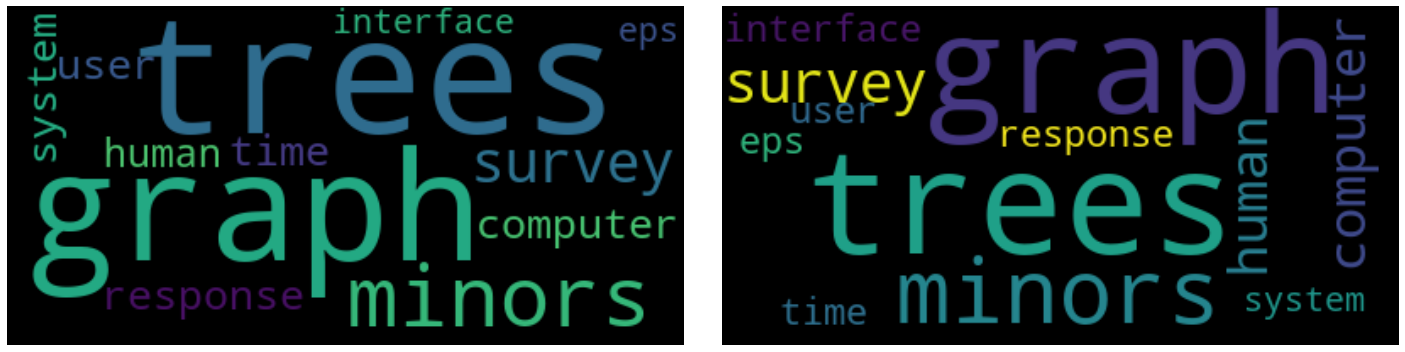

In [17]:
plot_word_cloud(w, lsi_model.id2word.id2token)

#### Min-Max Scaling with Adjustments To Negatives

Another way might be to assign zero to all negative numbers and then perform `min-max scaling`.

In [18]:
from sklearn import preprocessing

w = lsi_model.get_topics().copy()
w[w < 0] = 0.0
w = preprocessing.minmax_scale(w.T).T
w

array([[0.02926799, 0.        , 0.0082077 , 0.04426959, 0.23345434,
        0.04700873, 0.04426959, 0.04237633, 0.00773971, 1.        ,
        0.75430468, 0.55235244],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.47070483, 0.18249809]])

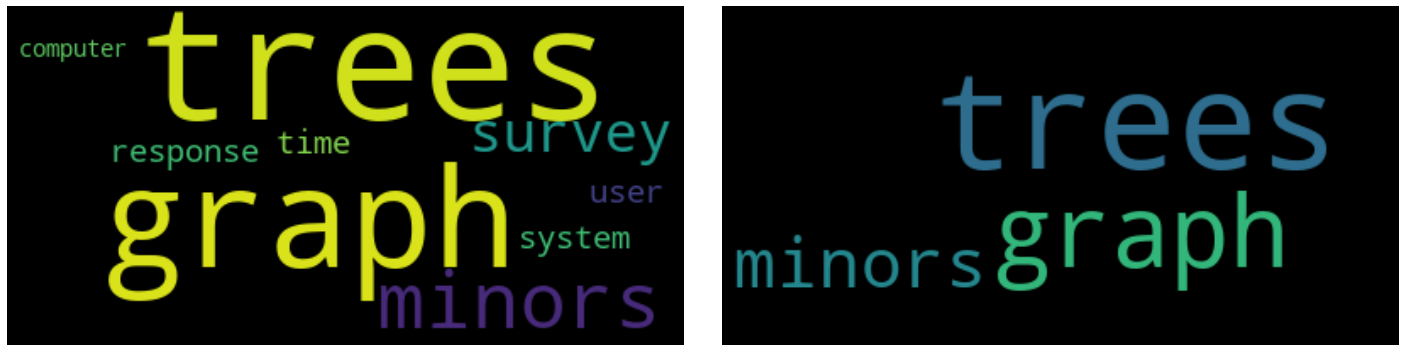

In [19]:
plot_word_cloud(w, lsi_model.id2word.id2token)

### LDA

The word weights per topics in LDA makes much more sense, as they must add to `1.0` per topic. These weights are probabilities.

In [20]:
w = lda_model.get_topics()
w

array([[0.08547547, 0.08562115, 0.06079486, 0.08466817, 0.05317843,
        0.13346857, 0.08209267, 0.09539039, 0.0600327 , 0.10682175,
        0.09265782, 0.05979805],
       [0.05053334, 0.05026537, 0.09593908, 0.05201848, 0.10995121,
        0.10076237, 0.05675674, 0.10155421, 0.09734126, 0.08052358,
        0.10658142, 0.097773  ]], dtype=float32)

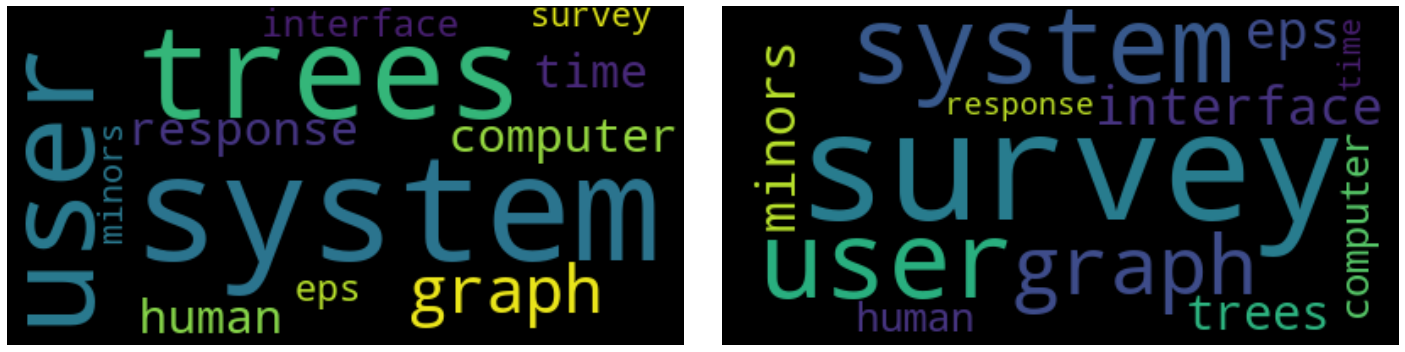

In [21]:
plot_word_cloud(w, lda_model.id2word.id2token)

## Coherence Scores

[Topic coherence](https://radimrehurek.com/gensim/models/coherencemodel.html) is a way to judge the quality of topics via a single quantitative, scalar value. There are many ways to compute the coherence score. For the `u_mass` and `c_v` options, a higher is always better. Note that `u_mass` is between -14 and 14 and `c_v` is between 0 and 1.

* -14 <= `u_mass` <= 14
* 0 <= `c_v` <= 1

The coherence score is an [aggregation](https://rare-technologies.com/what-is-topic-coherence/) of the following.

* segmentation
* probability estimation
* confirmation measure

### u_mass

Note with `u_mass` you always use `corpus=corpus_<model>`.

In [22]:
from gensim.models.coherencemodel import CoherenceModel

cm = CoherenceModel(model=lsi_model, corpus=corpus_lsi, coherence='u_mass')
cm.get_coherence()

-2.93056284562877

In [23]:
cm = CoherenceModel(model=lda_model, corpus=corpus_lda, coherence='u_mass')
cm.get_coherence()

-2.5119110105389435

### c_v

Note with `c_v` you have to pass in the tokenized text `texts=texts`.

In [24]:
cm = CoherenceModel(model=lsi_model, texts=texts, coherence='c_v')
cm.get_coherence()

0.3838413553737203

In [25]:
cm = CoherenceModel(model=lda_model, texts=texts, coherence='c_v')
cm.get_coherence()

0.3838413553737203

### Optimal Number of Topics

#### LSI

In [26]:
import pandas as pd

results = []

for t in range(2, 10):
    lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=t)
    corpus_lsi = lsi_model[corpus_tfidf]
    
    cm = CoherenceModel(model=lsi_model, corpus=corpus_lsi, coherence='u_mass')
    score = cm.get_coherence()
    tup = t, score
    results.append(tup)
    
results = pd.DataFrame(results, columns=['topic', 'score'])

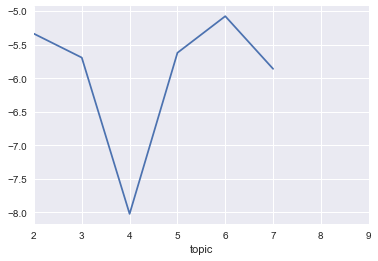

In [27]:
s = pd.Series(results.score, index=results.topic)
s.plot()

#### LDA

In [28]:
results = []

for t in range(2, 10):
    lda_model = models.LdaModel(corpus, id2word=dictionary, num_topics=t)
    corpus_lda = lda_model[corpus]
    
    cm = CoherenceModel(model=lsi_model, corpus=corpus_lda, coherence='u_mass')
    score = cm.get_coherence()
    tup = t, score
    results.append(tup)
    
results = pd.DataFrame(results, columns=['topic', 'score'])

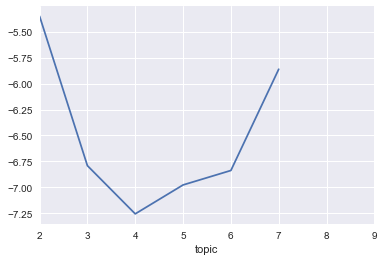

In [29]:
s = pd.Series(results.score, index=results.topic)
s.plot()

### k-means

For LSI, we may also use k-means and the [silhouette score](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html). This score is between -1 and 1. A score towards -1 indicates bad clustering, a score towards 0 indicates mixed-quality clustering (bad and good, let's suppose), and a score towards 1 indicates optimal clustering.

* -1 <= silhouette score <= 1

In [30]:
from sklearn.metrics import silhouette_score

results = []

for t in range(2, 20):
    lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=t)
    corpus_lsi = lsi_model[corpus_tfidf]
    
    X = np.array([[tup[1] for tup in arr] for arr in corpus_lsi])
    kmeans = KMeans(n_clusters=2, random_state=37).fit(X)
    
    score = silhouette_score(X, kmeans.labels_)
    
    tup = t, score
    results.append(tup)
    
results = pd.DataFrame(results, columns=['topic', 'score'])

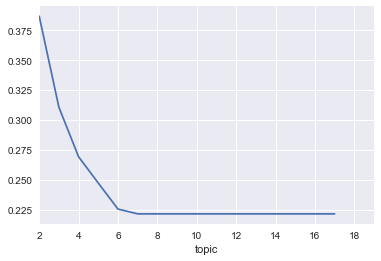

In [31]:
s = pd.Series(results.score, index=results.topic)
s.plot()